In [5]:
DATASET_PATH = '../data/raw/data_carrers.csv'
OUTPUT_PATH = '../data/processed/processed-dataset.csv'
import pandas as pd
import numpy as np
import torch
import random
import re
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig, AdamW, get_cosine_schedule_with_warmup
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import CrossEntropyLoss
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import matplotlib.pyplot as plt
import re
from transformers import MarianMTModel, MarianTokenizer, pipeline

# 1) Modelo para traducir de español a inglés
model_name_es_en = "Helsinki-NLP/opus-mt-es-en"
translator_es_en = pipeline(
    "translation_es_to_en",
    model=model_name_es_en,
    tokenizer=model_name_es_en
)

# 2) Modelo para traducir de inglés a español
model_name_en_es = "Helsinki-NLP/opus-mt-en-es"
translator_en_es = pipeline(
    "translation_en_to_es",
    model=model_name_en_es,
    tokenizer=model_name_en_es
)

def manual_back_translation(text, translator_es_en, translator_en_es):
    # 1) Traducir de español a inglés
    result_en = translator_es_en(text, max_length=512, truncation=True)
    # result_en es una lista de diccionarios [{'translation_text': "..."}]
    text_en = result_en[0]["translation_text"]

    # 2) Traducir la versión en inglés de vuelta a español
    result_es = translator_en_es(text_en, max_length=512, truncation=True)
    text_es = result_es[0]["translation_text"]

    return text_es





# Cargar el dataset
df = pd.read_csv(DATASET_PATH, encoding="UTF-8")


df_augmented_texts = []
df_augmented_labels = []

for idx, row in df.iterrows():
    original_text = row['TEXTO']
    label = row['CARRERA']

    # Genera, por ejemplo, 1 o 2 versiones back-translated
    # ¡Ojo! Esto puede ser lento si tu dataset es grande
    for _ in range(2):
        # Ejecutar la traducción ida y vuelta
        back_translated = manual_back_translation(
            original_text,
            translator_es_en,
            translator_en_es
        )
        df_augmented_texts.append(back_translated)
        df_augmented_labels.append(label)

# Crear el df de ejemplos aumentados
df_aug = pd.DataFrame({
    'TEXTO': df_augmented_texts,
    'CARRERA': df_augmented_labels
})

# Concatenar con el original
df_final = pd.concat([df, df_aug]).reset_index(drop=True)

df = df_final


# Eliminar valores nulos y duplicados
df = df.dropna()
df = df.drop_duplicates()
# Preprocesar el texto
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\sáéíóúñü]', '', text)  # Elimina caracteres especiales pero mantiene caracteres acentuados
    text = re.sub(r'\s+', ' ', text)  # Reemplaza múltiples espacios por uno solo
    text = text.strip()  # Elimina espacios en blanco al inicio y al final
    return text


df['TEXTO'] = df['TEXTO'].apply(preprocess_text)

# Mapear las categorías a índices numéricos
print(df['CARRERA'].unique())
categories = df['CARRERA'].unique().tolist()
category_to_index = {category: idx for idx, category in enumerate(categories)}
df['LABEL'] = df['CARRERA'].map(category_to_index)

texts = df['TEXTO'].tolist()
labels = df['LABEL'].tolist()

print(labels)


c:\Users\aleja\Desktop\Tesis\ML-Vocational-Interest-Project\venv\Lib\site-packages\transformers\models\marian\tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


['INDUSTRIAL' 'CIVIL' 'INFORMÁTICA' 'TELECOMUNICACIONES' 'ARQUITECTURA'
 'FILOSOFÍA' 'PSICOLOGÍA' 'LETRAS' 'COMUNICACIÓN SOCIAL' 'EDUCACIÓN'
 'ADMINISTRACIÓN' 'CONTADURÍA' 'RELACIONES INDUSTRIALES' 'SOCIOLOGÍA'
 'ECONOMÍA' 'DERECHO' 'TEOLOGÍA']
[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 

In [6]:


tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-cased')

inputs = tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")

input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']
labels = torch.tensor(labels)

dataset = TensorDataset(input_ids, attention_mask, labels)


In [7]:

# Convertir tensores a numpy arrays
input_ids_np = input_ids.numpy()
attention_mask_np = attention_mask.numpy()
labels_np = labels.numpy()

# División en entrenamiento+validación y prueba
X_train_val, X_test, y_train_val, y_test, mask_train_val, mask_test = train_test_split(
    input_ids_np, labels_np, attention_mask_np, test_size=0.2, random_state=42, stratify=labels_np)

# División en entrenamiento y validación
X_train, X_val, y_train, y_val, mask_train, mask_val = train_test_split(
    X_train_val, y_train_val, mask_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

print(y_train, y_val.shape, y_test.shape)
# Convertir a tensores
train_dataset = TensorDataset(torch.tensor(X_train,dtype=torch.long), torch.tensor(mask_train,dtype=torch.long), torch.tensor(y_train,dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val,dtype=torch.long), torch.tensor(mask_val,dtype=torch.long), torch.tensor(y_val,dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.long), torch.tensor(mask_test, dtype=torch.long), torch.tensor(y_test, dtype=torch.long))

# Crear DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(val_dataset, batch_size=32)
test_dataloader = DataLoader(test_dataset, batch_size=32)


config = BertConfig.from_pretrained('dccuchile/bert-base-spanish-wwm-cased', 
                                    num_labels=len(category_to_index), 
                                    hidden_dropout_prob=0.3, 
                                    attention_probs_dropout_prob=0.3)

model = BertForSequenceClassification.from_pretrained('dccuchile/bert-base-spanish-wwm-cased', config=config)

optimizer = AdamW(model.parameters(), lr=3e-5, weight_decay=0.01)

# Suponiendo que 'y_train' contiene las etiquetas de entrenamiento
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)


[ 2  4 13 ... 10 15  0] (386,) (387,)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\aleja\Desktop\Tesis\ML-Vocational-Interest-Project\venv\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [8]:
## BUCLE DE ENTRENAMIENTO

epochs = 45
total_steps = len(train_dataloader) * epochs
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=int(0.1 * total_steps), num_training_steps=total_steps)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
# Configurar el modelo en modo de entrenamiento

patience = 3
early_stopping_counter = 0
best_val_loss = float('inf')


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Después de calcular class_weights
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

loss_fn = CrossEntropyLoss(weight=class_weights)
model.to(device)
model.train()

training_losses = []
validation_losses = []
validation_accuracies = []
training_accuracies = []
training_f1_scores = []
validation_f1_scores = []  # Agrega esta línea aquí
learning_rates = []


for epoch in range(epochs):
    ### Entrenamiento ###
    model.train()
    total_train_loss = 0
    train_predictions = []
    train_true_labels = []

    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs} - Entrenamiento"):
        optimizer.zero_grad()
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fn(logits, labels)
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
                # Almacenar predicciones y etiquetas
        preds = torch.argmax(logits, dim=1)
        train_predictions.extend(preds.cpu().numpy())
        train_true_labels.extend(labels.cpu().numpy())
        
    learning_rates.append(optimizer.param_groups[0]['lr'])

    
    avg_train_loss = total_train_loss / len(train_dataloader)
    training_losses.append(avg_train_loss)
    
    # Calcular métricas de entrenamiento
    train_accuracy = accuracy_score(train_true_labels, train_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
    train_true_labels, train_predictions, average='weighted')
    training_accuracies.append(train_accuracy)
    training_f1_scores.append(f1)


    ### Validación ###
    model.eval()
    total_val_loss = 0
    val_predictions = []
    val_true_labels = []

    with torch.no_grad():
        for batch in tqdm(validation_dataloader, desc=f"Epoch {epoch+1}/{epochs} - Validación"):
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = loss_fn(logits, labels)
            total_val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            val_predictions.extend(preds.cpu().numpy())
            val_true_labels.extend(labels.cpu().numpy())
    
    avg_val_loss = total_val_loss / len(validation_dataloader)
    validation_losses.append(avg_val_loss)

    # Calcular precisión en validación
    val_accuracy = accuracy_score(val_true_labels, val_predictions)
    validation_accuracies.append(val_accuracy)
    
    # Después de calcular avg_val_loss y val_accuracy, agrega:
    precision, recall, f1, _ = precision_recall_fscore_support(
        val_true_labels, val_predictions, average='weighted')
    validation_f1_scores.append(f1)
    


    print(f"Epoch {epoch+1}/{epochs}, Pérdida Entrenamiento: {avg_train_loss:.4f}, Pérdida Validación: {avg_val_loss:.4f}, Precisión Validación: {val_accuracy:.4f}")
    
    # Definir variables para Early Stopping
    # Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), 'best_model_state.bin')  # Guarda el mejor modelo
    else:
        early_stopping_counter += 1
        print(f"No hay mejora en la pérdida de validación. Paciencia: {early_stopping_counter}/{patience}")

    if early_stopping_counter >= patience:
        print("Early Stopping activado")
        break

Epoch 1/45 - Validación: 100%|██████████| 13/13 [00:08<00:00,  1.53it/s]
c:\Users\aleja\Desktop\Tesis\ML-Vocational-Interest-Project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/45, Pérdida Entrenamiento: 2.8425, Pérdida Validación: 2.8337, Precisión Validación: 0.0596


Epoch 2/45 - Validación: 100%|██████████| 13/13 [00:09<00:00,  1.44it/s]
c:\Users\aleja\Desktop\Tesis\ML-Vocational-Interest-Project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2/45, Pérdida Entrenamiento: 2.8399, Pérdida Validación: 2.7995, Precisión Validación: 0.0622


Epoch 3/45 - Validación: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
c:\Users\aleja\Desktop\Tesis\ML-Vocational-Interest-Project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3/45, Pérdida Entrenamiento: 2.7653, Pérdida Validación: 2.5454, Precisión Validación: 0.3264


Epoch 4/45 - Validación: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]


Epoch 4/45, Pérdida Entrenamiento: 2.3466, Pérdida Validación: 1.5821, Precisión Validación: 0.6813


Epoch 5/45 - Validación: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]


Epoch 5/45, Pérdida Entrenamiento: 1.3750, Pérdida Validación: 0.7021, Precisión Validación: 0.8109


Epoch 6/45 - Validación: 100%|██████████| 13/13 [00:08<00:00,  1.50it/s]


Epoch 6/45, Pérdida Entrenamiento: 0.7667, Pérdida Validación: 0.5036, Precisión Validación: 0.8601


Epoch 7/45 - Validación: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s]


Epoch 7/45, Pérdida Entrenamiento: 0.4689, Pérdida Validación: 0.3648, Precisión Validación: 0.8990


Epoch 8/45 - Validación: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]


Epoch 8/45, Pérdida Entrenamiento: 0.3240, Pérdida Validación: 0.4141, Precisión Validación: 0.8990
No hay mejora en la pérdida de validación. Paciencia: 1/3


Epoch 9/45 - Validación: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s]


Epoch 9/45, Pérdida Entrenamiento: 0.2459, Pérdida Validación: 0.2969, Precisión Validación: 0.9119


Epoch 10/45 - Validación: 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]


Epoch 10/45, Pérdida Entrenamiento: 0.1899, Pérdida Validación: 0.3243, Precisión Validación: 0.9067
No hay mejora en la pérdida de validación. Paciencia: 1/3


Epoch 11/45 - Validación: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s]


Epoch 11/45, Pérdida Entrenamiento: 0.1835, Pérdida Validación: 0.2957, Precisión Validación: 0.9145


Epoch 12/45 - Validación: 100%|██████████| 13/13 [00:09<00:00,  1.36it/s]


Epoch 12/45, Pérdida Entrenamiento: 0.1086, Pérdida Validación: 0.3104, Precisión Validación: 0.9223
No hay mejora en la pérdida de validación. Paciencia: 1/3


Epoch 13/45 - Validación: 100%|██████████| 13/13 [00:08<00:00,  1.49it/s]


Epoch 13/45, Pérdida Entrenamiento: 0.0952, Pérdida Validación: 0.3437, Precisión Validación: 0.9145
No hay mejora en la pérdida de validación. Paciencia: 2/3


Epoch 14/45 - Validación: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]

Epoch 14/45, Pérdida Entrenamiento: 0.0765, Pérdida Validación: 0.4403, Precisión Validación: 0.9093
No hay mejora en la pérdida de validación. Paciencia: 3/3
Early Stopping activado


Evaluación en Conjunto de Prueba: 100%|██████████| 13/13 [00:09<00:00,  1.33it/s]


                         precision    recall  f1-score   support

             INDUSTRIAL       0.96      0.96      0.96        27
                  CIVIL       1.00      0.96      0.98        25
            INFORMÁTICA       0.88      0.92      0.90        24
     TELECOMUNICACIONES       0.92      0.92      0.92        24
           ARQUITECTURA       0.96      1.00      0.98        22
              FILOSOFÍA       1.00      1.00      1.00        22
             PSICOLOGÍA       0.92      1.00      0.96        24
                 LETRAS       0.83      1.00      0.91        20
    COMUNICACIÓN SOCIAL       1.00      0.78      0.88        23
              EDUCACIÓN       1.00      1.00      1.00        21
         ADMINISTRACIÓN       0.82      1.00      0.90        23
             CONTADURÍA       0.95      0.87      0.91        23
RELACIONES INDUSTRIALES       1.00      0.91      0.95        22
             SOCIOLOGÍA       0.95      0.91      0.93        22
               ECONOMÍA 

<Figure size 1800x500 with 0 Axes>

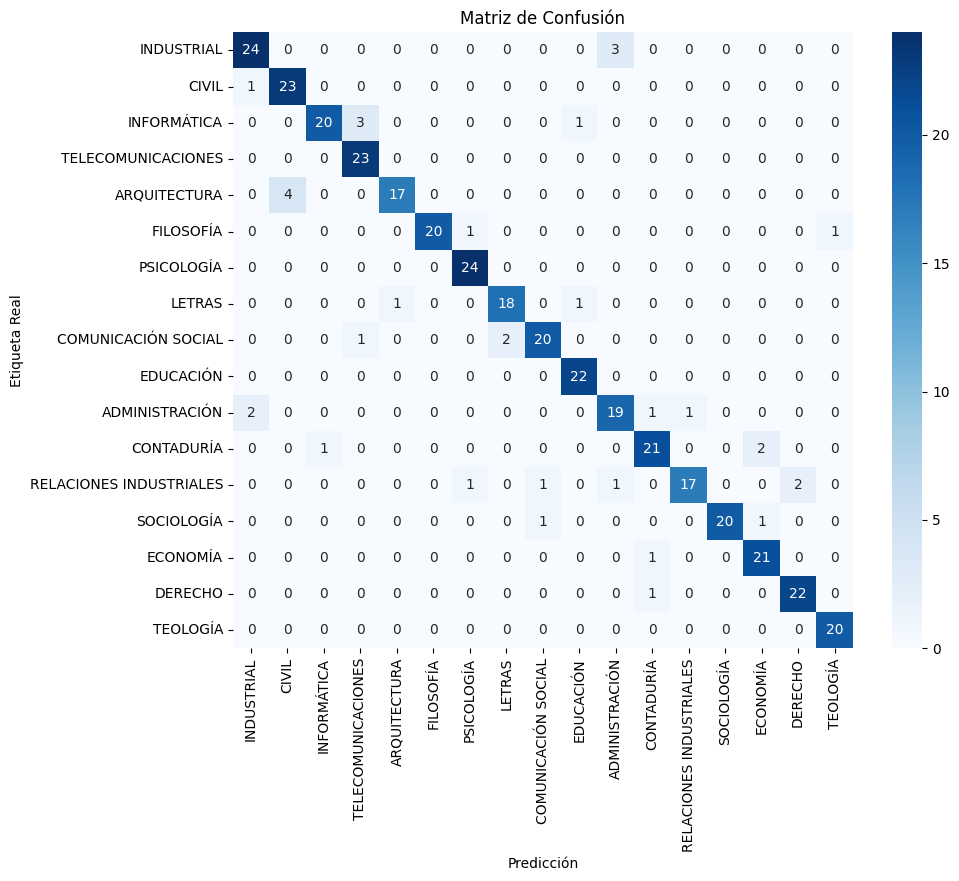

ValueError: x and y must have same first dimension, but have shapes (45,) and (14,)

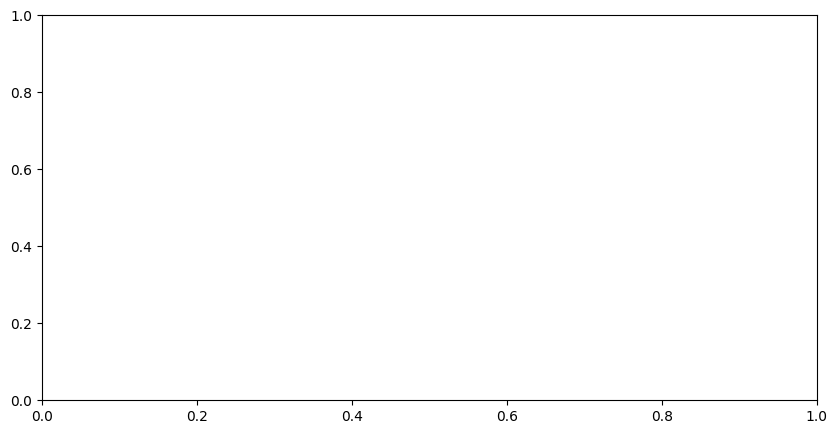

In [9]:
# Cargar el mejor modelo
model.load_state_dict(torch.load('best_model_state.bin', weights_only=True))

model.eval()
test_predictions = []
test_true_labels = []

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Evaluación en Conjunto de Prueba"):
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        test_predictions.extend(preds.cpu().numpy())
        test_true_labels.extend(labels.cpu().numpy()) 

# Generar el reporte de clasificación
from sklearn.metrics import classification_report

print(classification_report(test_true_labels, test_predictions, target_names=categories))

  
## MONITOREO DE GRÁFICOS Y METRICAS

epochs_range = range(1, len(training_losses) + 1)

plt.figure(figsize=(18, 5))

#generar matriz de confusion para la justificacion de la escogencia del algoritmo

######CODIGO A IMPLEMENTAR ######

import seaborn as sns

# Obtener la matriz de confusión en el conjunto de validación
conf_matrix = confusion_matrix(val_true_labels, val_predictions)

# Visualizar la matriz de confusión con un heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')
plt.show()

# generar la grafica de learning rate (curva de aprendizaje)


# Graficar la tasa de aprendizaje durante el entrenamiento
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), learning_rates, label="Tasa de Aprendizaje")
plt.xlabel('Épocas')
plt.ylabel('Tasa de Aprendizaje')
plt.title('Curva de Tasa de Aprendizaje durante el Entrenamiento')
plt.legend()
plt.show()
####### CODIGO A IMPLEMENTAR ######

# Gráfica de pérdidas
plt.subplot(1, 3, 1)
plt.plot(epochs_range, training_losses, label='Pérdida de Entrenamiento')
plt.plot(epochs_range, validation_losses, label='Pérdida de Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Pérdida por Época')

# Gráfica de precisión
plt.subplot(1, 3, 2)
plt.plot(epochs_range, training_accuracies, label='Precisión de Entrenamiento')
plt.plot(epochs_range, validation_accuracies, label='Precisión de Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.title('Precisión por Época')

# Gráfica de F1-score
plt.subplot(1, 3, 3)
plt.plot(epochs_range, training_f1_scores, label='F1-score de Entrenamiento')
plt.plot(epochs_range, validation_f1_scores, label='F1-score de Validación')
plt.xlabel('Épocas')
plt.ylabel('F1-score')
plt.legend()
plt.title('F1-score por Época')

plt.tight_layout()
plt.show()


Para reforzar la justificación de la implementación, podrías generar más gráficas que incluyan:

Curva ROC y AUC:

La Curva ROC (Receiver Operating Characteristic) muestra el rendimiento del modelo en clasificación binaria, y el AUC (Area Under Curve) indica qué tan bien puede distinguir el modelo entre las clases. Esto es especialmente útil si estás trabajando con clasificación binaria (por ejemplo, clasificar respuestas como positivas o negativas).
Matriz de confusión:

La matriz de confusión te muestra cómo el modelo está clasificando las respuestas en cada clase. Esto puede proporcionar una comprensión más profunda de cómo el modelo está manejando cada categoría de respuesta en el contexto de orientación vocacional.
Learning Rate Curve:

Una gráfica del learning rate a lo largo del tiempo puede proporcionar información sobre cómo la tasa de aprendizaje está influyendo en el rendimiento del modelo.
¿Te gustaría que genere alguna de estas gráficas adicionales para complementar la justificación del modelo que has implementado?